In [2]:
#Imports:
#General imports
import numpy as np
import pandas as pd



# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [3]:
#Imports:
#Storing the model
import joblib

In [4]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Other models
from xgboost import XGBClassifier


#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
def nan_vis(df):
    """
    Visualizes missing values in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - str: A message indicating if there are any missing values or not.
    - If there are missing values, returns a bar graph with the missing values.
    """

    # Visualize missing values
    if df.isna().sum().sum() == 0:
        return "There are no missing values"
    else:
        plt.figure(figsize=(10, 6))
        plt.title("Missing Values")
        ax = sns.barplot(x=df.columns, y=df.isna().sum())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.xlabel("Columns")
        plt.ylabel("Missing Values Count")
        plt.show()

In [ ]:
def replace_nan_with_zero(df, columns):
    """
    Replaces the NaN values with 0

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - List columns of the DataFrame that will be removed.

    Returns:
    - df (pandas.DataFrame): The input DataFrame with the updated values
    """
    df[columns] = df[columns].fillna(0)
    return df

In [6]:
dfmodel = pd.read_csv('../data/elenas-it2-postpreprocessing.csv')

In [7]:
nan_vis(dfmodel)

'There are no missing values'

In [8]:

dfmodel["churn"].value_counts()

1    38760
0     8944
Name: churn, dtype: int64

In [9]:
dfmodel.drop(["seller_created_at"], axis=1, inplace=True)

In [10]:
#Splitting the variables
X = dfmodel.drop(columns="churn")
y = dfmodel["churn"]

#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [11]:
#Fitting the baseline model
baseline_dt = DecisionTreeClassifier(max_depth=2)
baseline_cv = cross_val_score(baseline_dt, X_train, y_train, cv=5)
baseline_fitted = baseline_dt.fit(X_train, y_train)


In [12]:
#Baseline scores:

# Predict labels
y_pred = baseline_fitted.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = baseline_fitted.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
""")


- Baseline accuracy: 0.8816685881983021
- Baseline recall: 0.9872291021671826
- Baseline precision: 0.8813774041229989
- Baseline f1: 0.9313051414663827



Baseline recall of the negative class: Include it into the baseline

In [13]:
#Check for overfitting
print(f"overfitting - train model score: {baseline_fitted.score(X_train, y_train)}")

overfitting - train model score: 0.882137148547022


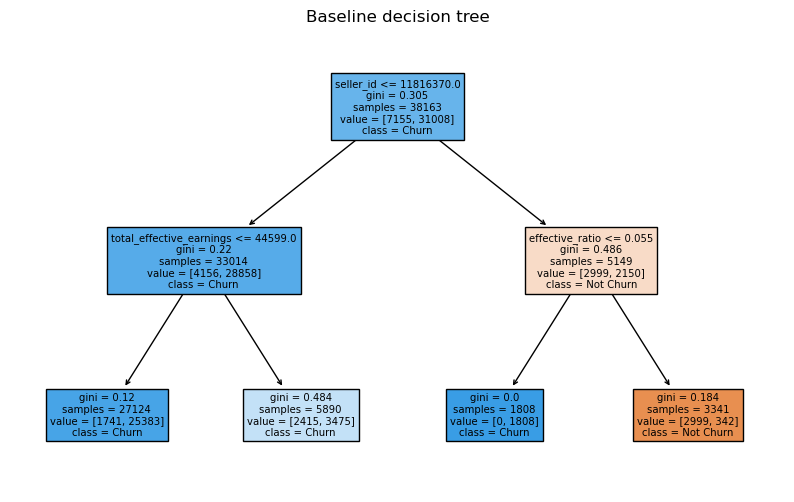

In [14]:
# Plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(baseline_fitted, feature_names=X_train.columns, filled=True, class_names=["Not Churn", "Churn"], impurity=True)
plt.title("Baseline decision tree")
plt.show()

## Random Forest

Iteration 1
{'model': RandomForestClassifier(max_depth=200),
 'model__max_depth': 200,
 'normalise': StandardScaler(),
 'select': None}

- Baseline accuracy: 0.9391049156272927
- Baseline recall: 0.9837461300309598
- Baseline precision: 0.943695087241678
- Baseline f1: 0.9633044906208552

overfitting - train model score: 1.0

There is already overfitting

Iteration 2: depth range 'model__max_depth': [10, 12, 200],
{'model': RandomForestClassifier(max_depth=200),
 'model__max_depth': 200,
 'normalise': None,
 'select': None}
- Baseline accuracy: 0.9401530237920553
- Baseline recall: 0.9850361197110423
- Baseline precision: 0.9437646768013842
- Baseline f1: 0.9639588461781228

Iteration 3: include min sample split
param_grid = [
    {
        'model': [RandomForestClassifier()],
        'normalise': [StandardScaler(), None],
        'model__max_depth': [10, 12, 15, 20],
        'model__min_samples_split': [2, 4, 6, 12],
        'select':  [ None],

Best Params:
{'model': RandomForestClassifier(max_depth=20, min_samples_split=6),
 'model__max_depth': 20,
 'model__min_samples_split': 6,
 'normalise': StandardScaler(),
 'select': None}

- Baseline accuracy: 0.9383712399119589
- Baseline recall: 0.9842621259029928
- Baseline precision: 0.9424407114624506
- Baseline f1: 0.9628975265017667

 

In [17]:
#Random Forest gridsearch:
estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", RandomForestClassifier())
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [RandomForestClassifier()],
        'normalise': [StandardScaler(), None],
        'model__max_depth': [20],
        'model__min_samples_split': [6],
        'select':  [ None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
rf_fitted_grid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [18]:
rf_fitted_grid.best_params_

{'model': RandomForestClassifier(max_depth=20, min_samples_split=6),
 'model__max_depth': 20,
 'model__min_samples_split': 6,
 'normalise': StandardScaler(),
 'select': None}

In [47]:
#DT iteration 1

# Predict labels
y_pred = rf_fitted_grid.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = rf_fitted_grid.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
""")


- Baseline accuracy: 0.9383712399119589
- Baseline recall: 0.9842621259029928
- Baseline precision: 0.9424407114624506
- Baseline f1: 0.9628975265017667



In [46]:
print(f"overfitting - train model score: {rf_fitted_grid.score(X_train, y_train)}")

overfitting - train model score: 0.9890731860702775


## XGBoost

In [105]:
estimators = [
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [5, 10, 20],
    'model__colsample_bytree': [0.3, 0.5, 0.8],  # Hyperparameter for XGBoost
    'model__reg_alpha': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__learning_rate': [0.01, 0.1, 1],  # Hyperparameter for XGBoost
    'model__gamma':[0.01, 0.1, 1, 10],
    'model__n_estimators': [1, 10],
    'model__scale_pos_weight': [0.1, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
xgb_fitted_grid = grid.fit(X_train, y_train)

Fitting 3 folds for each of 13824 candidates, totalling 41472 fits


In [107]:
xgb_fitted_grid.best_params_

{'model__colsample_bytree': 0.8,
 'model__gamma': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 20,
 'model__n_estimators': 10,
 'model__reg_alpha': 1,
 'model__reg_lambda': 0.5,
 'model__scale_pos_weight': 1}

In [110]:
xgb_fitted_grid.score(X_test, y_test)

0.9405722670579604

In [111]:
xgb_fitted_grid.score(X_train, y_train)

0.9765741686974294

In [113]:
#XGBoost

# Predict labels
y_pred = xgb_fitted_grid.predict(X_test)

# Accuracy, Precision, recall, and F1-score
accuracy = xgb_fitted_grid.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
- Baseline accuracy: {accuracy}
- Baseline recall: {recall}
- Baseline precision: {precision}
- Baseline f1: {f1}
""")


- Baseline accuracy: 0.9405722670579604
- Baseline recall: 0.9827141382868937
- Baseline precision: 0.9462178611352627
- Baseline f1: 0.9641207365690058



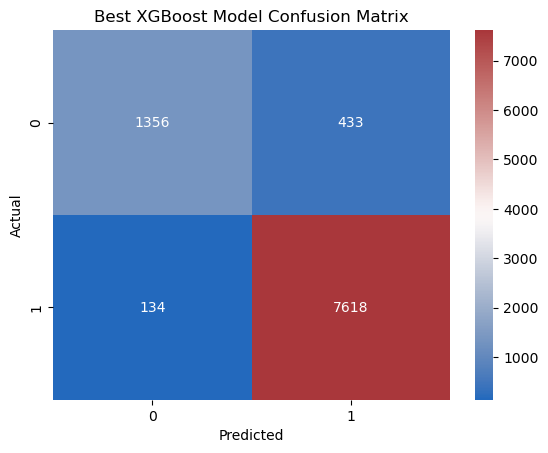

In [115]:
# Confusion Matrix
cmx = confusion_matrix(y_test, xgb_fitted_grid.predict(X_test), labels=xgb_fitted_grid.best_estimator_.classes_)

# Set the font color of values inside the matrix to white
sns.heatmap(cmx, annot=True, cmap='vlag', fmt='d', annot_kws={"color": "white"})


plt.title("Best XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [116]:
#Negative Predictive Value = TN / (TN + FN)
print(f"Negative Predictive Value: {1356 /(1356 + 134)}")

#True Negative Ratio = TN / (TN + FP)
print(f"True Negative ratio: {1356 / (1356 + 433)}")

Negative Predictive Value: 0.9100671140939597
True Negative ratio: 0.7579653437674678


In [117]:
xgdepth = np.arange(1, 25)

In [19]:
#Split:

#Train and test split
X_train_tempxg, X_valxg, y_train_tempxg, y_valxg = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=24)

#Lists:

accuracy_testxg = []
accuracy_trainxg = []

recall_final = []

#Model: 
for depth in xgdepth:
    it2_xg = XGBClassifier(max_depth=depth)
    #it2_cv = cross_val_score(it2_rf, X_train, y_train, cv=5)
    it2_fitted = it2_xg.fit(X_train_tempxg, y_train_tempxg)
    accuracy_testxg.append(it2_fitted.score(X_valxg, y_valxg))
    accuracy_trainxg.append(it2_fitted.score(X_train_tempxg, y_train_tempxg))
    y_pred = it2_fitted.predict(X_valxg)
    recall_final.append(recall_score(y_valxg, y_pred))

NameError: name 'xgdepth' is not defined

In [119]:
fig = go.Figure()

# Accuracy test
fig.add_trace(go.Scatter(x=xgdepth, y=accuracy_testxg, name='Accuracy Test', line=dict(color='red')))

# Accuracy_train
fig.add_trace(go.Scatter(x=xgdepth, y=accuracy_trainxg, name='Accuracy Train', line=dict(color='slateblue')))

# Set the layout with titles
fig.update_layout(
    title='XGBoost overfitting: accuracy and depth',
    xaxis_title='Depths',
    yaxis_title='Accuracy',
    legend_title='Accuracy',
)

# Show the figure
fig.show()

In [15]:
#XGBoost It 2
estimators = [
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [5],
    'model__colsample_bytree': [ 0.9],  # Hyperparameter for XGBoost
    'model__reg_alpha': [1 ],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0.5],  # Hyperparameter for XGBoost
    'model__learning_rate': [1],  # Hyperparameter for XGBoost
    'model__gamma':[0.1,],
    'model__n_estimators': [100, 150, 200, 500],
    'model__scale_pos_weight': [1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
xgb_fitted_grid2 = grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [16]:
print(xgb_fitted_grid2.best_params_)

{'model__colsample_bytree': 0.9, 'model__gamma': 0.1, 'model__learning_rate': 1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 0.5, 'model__scale_pos_weight': 1}


In [17]:
xgb_fitted_grid2.score(X_test, y_test)


0.9405722670579604

In [24]:
#ROC XGB it 2
# Predicted probabilities from the fitted grid search
y_pred_prob = xgb_fitted_grid2.predict_proba(X_test)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagonal line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='ROC Curve: XGBoost',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='Recall'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()

## Random Forest optimization:

In [33]:
## Parameters

depths = np.arange(1,75)


In [40]:
#Split:

#Train and test split
X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=24)

#Lists:

accuracy_test = []
accuracy_train = []

recall_final = []

#Model: 
for depth in depths:
    it2_rf = RandomForestClassifier(max_depth=depth)
    #it2_cv = cross_val_score(it2_rf, X_train, y_train, cv=5)
    it2_fitted = it2_rf.fit(X_train_temp, y_train_temp)
    accuracy_test.append(it2_fitted.score(X_val, y_val))
    accuracy_train.append(it2_fitted.score(X_train_temp, y_train_temp))
    y_pred = it2_fitted.predict(X_val)
    recall_final.append(recall_score(y_val, y_pred))


In [25]:
len(accuracy_test)

18

In [83]:
# Overfitting review
fig = go.Figure()

# Add the first line trace for accuracy_test
fig.add_trace(go.Scatter(x=depths, y=accuracy_test, name='Accuracy Test', line=dict(color='red')))

# Add the second line trace for accuracy_train
fig.add_trace(go.Scatter(x=depths, y=accuracy_train, name='Accuracy Train', line=dict(color='slateblue')))

# Set the layout with titles
fig.update_layout(
    title='Model overfitting: accuracy and depth',
    xaxis_title='Depths',
    yaxis_title='Accuracy',
    legend_title='Accuracy',
)

# Show the figure
fig.show()



Visualize best and worse variables

PRecision and recall of the negative class

Review the cases that the model was wrong with y_test, filtering to see patterns

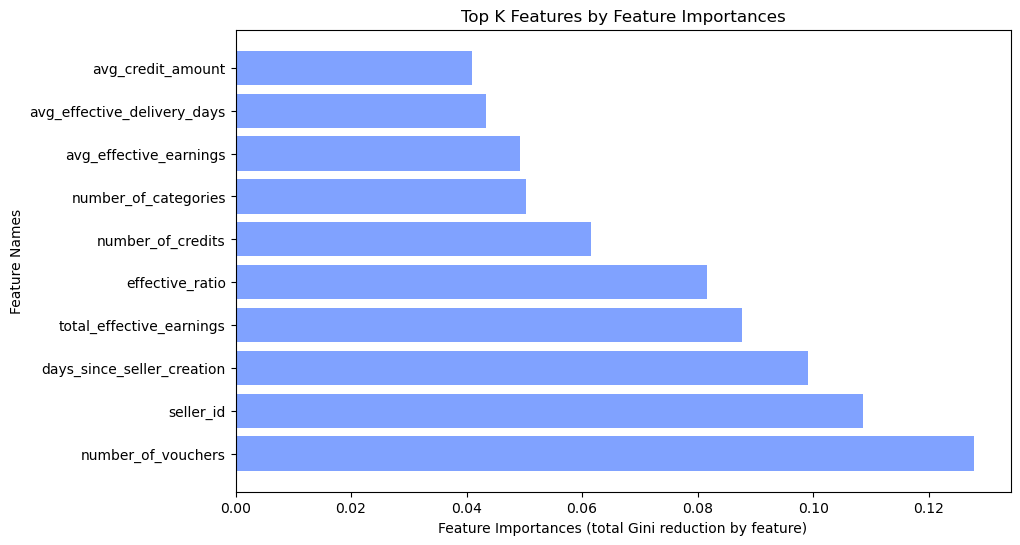

In [75]:
#Feature importance visualization
random_forest = rf_fitted_grid.best_estimator_.named_steps['model']

# Retrieve the features with their respective n ames
feature_importances = random_forest.feature_importances_


feature_names = X_train.columns

# Sort the feature importances desc
indices = np.argsort(feature_importances)[::-1]

#Top K features
top_k_indices = indices[:10]  

# Feature names for the top K features
top_k_feature_names = feature_names[top_k_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_k_feature_names)), feature_importances[top_k_indices], align='center', color="#80a2ff")
plt.yticks(range(len(top_k_feature_names)), top_k_feature_names)
plt.xlabel('Feature Importances (total Gini reduction by feature)')
plt.ylabel('Feature Names')
plt.title('Top K Features by Feature Importances')
plt.show()

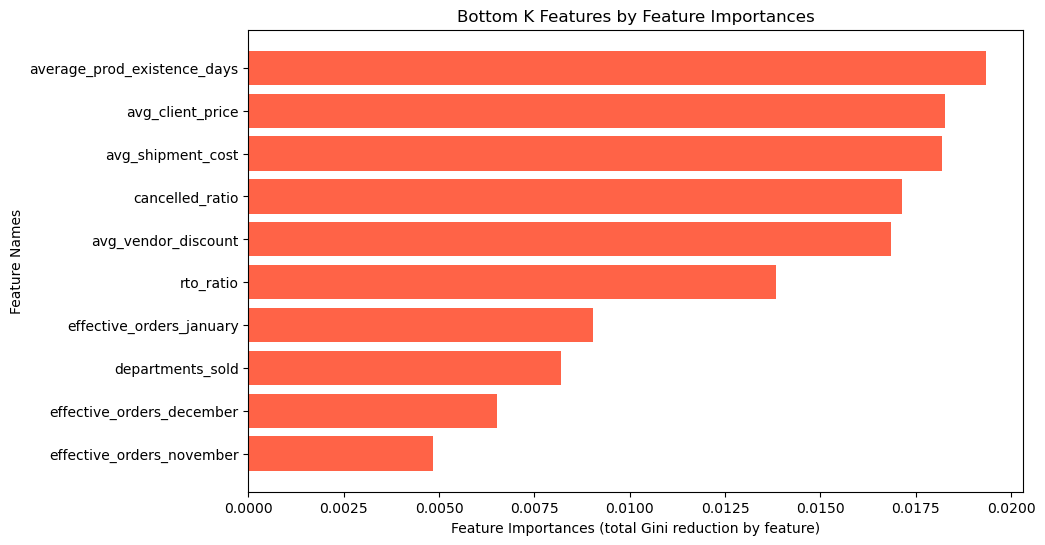

In [66]:
# Indices of the bottom K features
bottom_k_indices = feature_importances.argsort()[4:14]

# Feature names for the bottom K features
bottom_k_feature_names = feature_names[bottom_k_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(bottom_k_feature_names)), feature_importances[bottom_k_indices], align='center', color="tomato")
plt.yticks(range(len(bottom_k_feature_names)), bottom_k_feature_names)
plt.xlabel('Feature Importances (total Gini reduction by feature)')
plt.ylabel('Feature Names')
plt.title('Bottom K Features by Feature Importances')
plt.show()

**Confusion Matrix**

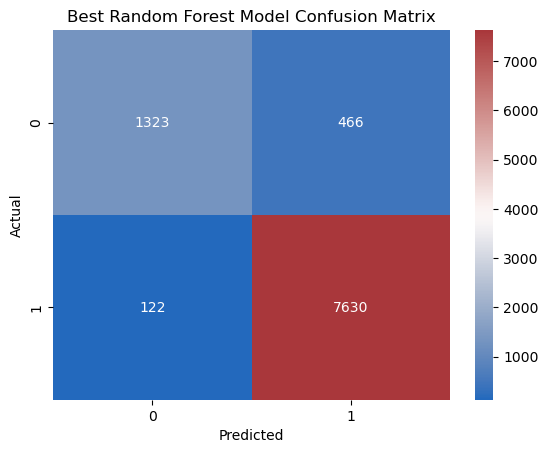

In [71]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_fitted_grid.predict(X_test), labels=rf_fitted_grid.best_estimator_.classes_)

# Set the font color of values inside the matrix to white
sns.heatmap(cm, annot=True, cmap='vlag', fmt='d', annot_kws={"color": "white"})


plt.title("Best Random Forest Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [94]:
#Negative Predictive Value = TN / (TN + FN)
print(f"Negative Predictive Value: {1323 /(1323 + 122)}")

#True Negative Ratio = TN / (TN + FP)
print(f"True Negative ratio: {1323 / (1323 + 466)}")


Negative Predictive Value: 0.9155709342560554
True Negative ratio: 0.7395192845164896


In [1]:
# Predicted probabilities from the fitted grid search
y_pred_prob = rf_fitted_grid.predict_proba(X_test)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagonal line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='ROC Curve: Random Forest',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='Recall'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()

NameError: name 'rf_fitted_grid' is not defined

In [101]:
#Saving the model:
joblib.dump(rf_fitted_grid, '../model/it2_random_forest.pkl')
            

['../model/it2_random_forest.pkl']

In [18]:
#Saving the model:
joblib.dump(xgb_fitted_grid2, '../model/it2_xgboost.pkl')

['../model/it2_xgboost.pkl']